# Use the blog dataset

In [1]:
import pandas as pd
from data_utils import splitter, seed_all, normalize
import numpy as np
import torch
from src.models import vanilla_predNet, MC_dropnet, Deep_Ensemble
from src.losses import *
from Experiments.EXP1.TestPerform import testPerform_muSigma


raw_df = pd.read_csv("Dataset/BlogFeedback/blogData_train.csv", header = None)

x = raw_df.iloc[:, :280].to_numpy()

y = raw_df.iloc[:, 280].to_numpy()

# we only select those y >= 1

x = x[y >= 1]
y = y[y >= 1]

y = np.clip(np.log(y), 0, 7)

SEED = 1234

seed_all(SEED)

x_normed, x_normalizer = normalize(x)

x = x_normed

N_train = int(len(x) * 0.9)
N_test = int(len(x) * 0.1)

tr_idx = np.arange(len(x))[:N_train]

te_idx = np.arange(len(x))[N_train:N_train+N_test]


test_X, test_Y = x[te_idx], y[te_idx]



x_reshaped, y_reshaped = x[tr_idx], y[tr_idx]


N_model_train = int(len(y_reshaped) * 0.7)
N_recalibration = int(len(y_reshaped) * 0.3)

tr_new_idx, recal_idx = splitter(N_model_train, N_recalibration, seed = SEED)


recal_X = x_reshaped[recal_idx]
recal_Y = y_reshaped[recal_idx]



x_remain, y_remain = x_reshaped[tr_new_idx], y_reshaped[tr_new_idx]


split = 0.8
train_idx, val_idx = splitter(int(split * len(y_remain)), len(y_remain) - int(split * len(y_remain)), seed = SEED)


train_X, train_Y = x_remain[train_idx], y_remain[train_idx]
val_X, val_Y = x_remain[val_idx], y_remain[val_idx]

n_feature = x.shape[1]

epochs = 300


train_X = torch.Tensor(train_X)
train_Y = torch.Tensor(train_Y).view(-1).cuda()
val_X = torch.Tensor(val_X)
val_Y = torch.Tensor(val_Y).view(-1).cuda()
test_X = torch.Tensor(test_X)
test_Y = torch.Tensor(test_Y).view(-1).cuda()

recal_X = torch.Tensor(recal_X)
recal_Y = torch.Tensor(recal_Y).view(-1).cuda()


(array([8595., 2774., 2359., 1816., 1341.,  805.,  557.,  337.,  202.,
          52.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

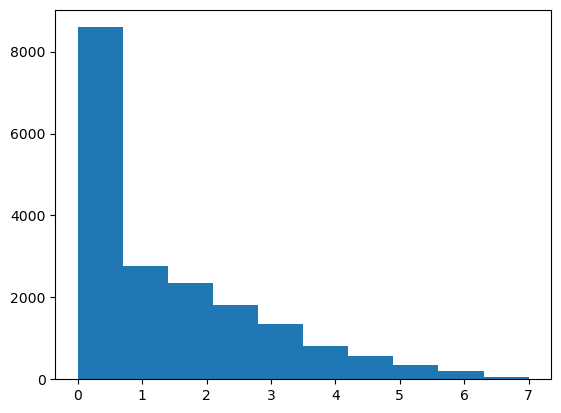

In [31]:
import matplotlib.pyplot as plt

plt.hist(y)

# Benchmark, deep ensemble

In [2]:
# benchmark, deep ensebmle
hidden = [100, 20]

print("Training model with hidden: ", hidden)
deepEnsemble_model = Deep_Ensemble(
    n_input = n_feature,
    hidden_layers = hidden
)
deepEnsemble_model.train(
    train_X, train_Y, val_X, val_Y,
    bat_size = 64,
    LR = 5E-4,

    N_Epoch = epochs,
    validate_times = 20,
    verbose = True,
    train_loss = mean_std_forEnsemble,
    val_loss_criterias = {
        "nll" : mean_std_forEnsemble,
        "rmse": rmse_loss,
        "MACE": MACE_muSigma
    },
    early_stopping = True,
    patience = 20,
    monitor_name = "rmse"
)

record = testPerform_muSigma(test_X, test_Y, model_name= "DeepEnsemble", model = deepEnsemble_model)

print(record)
    
    



Training model with hidden:  [100, 20]
epoch  0
     loss: nll, 0.6890813708305359
     loss: rmse, 1.2517714500427246
     loss: MACE, 0.027405934408307076
epoch  15
     loss: nll, 0.5831588506698608
     loss: rmse, 1.1078665256500244
     loss: MACE, 0.03899054601788521
epoch  30
     loss: nll, 0.7696754932403564
     loss: rmse, 1.1240923404693604
     loss: MACE, 0.04635414853692055
Early Stopped at Epoch  40
{'rmse_loss': 1.6169012784957886, 'mean_std_norm_loss': 1.592037320137024, 'MACE_muSigma': 0.08714040368795395, 'AGCE_muSigma': 0.09966491162776947, 'CheckScore_muSigma': 0.34913888573646545}


In [37]:
test_Y[:10]

tensor([1.3863, 0.0000, 0.0000, 0.0000, 1.0986, 0.0000, 0.6931, 0.0000, 0.0000,
        0.6931], device='cuda:0')

In [38]:
deepEnsemble_model.predict(test_X[:10])

tensor([[1.5531, 0.4687],
        [1.0844, 0.2462],
        [0.7312, 0.2217],
        [1.0458, 0.3553],
        [1.0856, 0.5783],
        [0.4786, 0.2815],
        [0.6131, 0.7375],
        [2.1985, 0.3860],
        [1.2352, 0.2546],
        [0.7082, 0.2603]], device='cuda:0', grad_fn=<StackBackward0>)

# HNN network is not doing good. We check the post recalibrate method. 

In [2]:
hidden = [100, 10]

print("Training model with hidden: ", hidden)
pred_model = vanilla_predNet(
    n_input = n_feature,
    hidden_layers = hidden
)
pred_model.train(
    train_X, train_Y, val_X, val_Y,
    bat_size = 64,
    LR = 1E-2,

    N_Epoch = epochs,
    validate_times = 20,
    verbose = True,
    train_loss = mse_loss,
    val_loss_criterias = {
        "mse": mse_loss,
        "rmse": rmse_loss,
    },
    early_stopping = True,
    patience = 20,
    monitor_name = "rmse"
)

rmse_loss(pred_model(test_X), test_Y)

Training model with hidden:  [100, 10]
epoch  0
     loss: mse, 1.428754448890686
     loss: rmse, 1.1953052282333374
epoch  15
     loss: mse, 1.2855403423309326
     loss: rmse, 1.1338167190551758
epoch  30
     loss: mse, 1.2759419679641724
     loss: rmse, 1.1295759677886963
epoch  45
     loss: mse, 1.2598309516906738
     loss: rmse, 1.1224218606948853
Early Stopped at Epoch  48


tensor(1.5838, device='cuda:0', grad_fn=<SqrtBackward0>)

# Also consider random forest model

In [53]:
from sklearn.ensemble import RandomForestRegressor

depth = 10

rf_model = RandomForestRegressor(max_depth=depth, random_state=0)
rf_model.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())

rmse_loss(torch.Tensor(rf_model.predict(test_X.cpu().numpy())).cuda(), test_Y)

tensor(1.0244, device='cuda:0')

In [54]:
from sklearn.linear_model import Ridge

alpha = 0.5

ridge_model = Ridge(alpha = alpha)
    
ridge_model.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())

rmse_loss(torch.Tensor(ridge_model.predict(test_X.cpu().numpy())).cuda(), test_Y)

tensor(1.2591, device='cuda:0')

# use random forest as base model, to check the influence of projection dimension

In [5]:
from Experiments.EXP1.TestPerform import testPerform_projKernel
from sklearn import random_projection

n_component = 3
transformer = random_projection.GaussianRandomProjection(n_components = n_component)
reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

for width in [5, 10, 20]:
    print(width)
    
    record = testPerform_projKernel(
        test_X, test_Y, recal_X, recal_Y, 
        model_name = "vanillaKernel_RandomProj", model= pred_model, reformer= reformer, wid = width) 
    
    print(record)




5
{'MACE_Loss': 0.030046414583921432, 'AGCE_Loss': 0.06269697844982147, 'CheckScore': 0.3656562864780426}
10
{'MACE_Loss': 0.028883380815386772, 'AGCE_Loss': 0.05828697979450226, 'CheckScore': 0.35126444697380066}
20
{'MACE_Loss': 0.030182234942913055, 'AGCE_Loss': 0.06343589723110199, 'CheckScore': 0.3432447016239166}


In [6]:
from Experiments.EXP1.TestPerform import testPerform_projKernel
from sklearn import random_projection

n_component = 10
transformer = random_projection.GaussianRandomProjection(n_components = n_component)
reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

for width in [10, 20, 30]:
    print(width)
    
    record = testPerform_projKernel(
        test_X, test_Y, recal_X, recal_Y, 
        model_name = "vanillaKernel_RandomProj", model= pred_model, reformer= reformer, wid = width) 
    
    print(record)



10
{'MACE_Loss': 0.03994020074605942, 'AGCE_Loss': 0.06185375526547432, 'CheckScore': 0.3454729914665222}
20
{'MACE_Loss': 0.031265612691640854, 'AGCE_Loss': 0.06667883694171906, 'CheckScore': 0.344874769449234}
30
{'MACE_Loss': 0.030824823305010796, 'AGCE_Loss': 0.057464711368083954, 'CheckScore': 0.34284457564353943}


In [7]:
from Experiments.EXP1.TestPerform import testPerform_projKernel
from sklearn import random_projection

n_component = 50
transformer = random_projection.GaussianRandomProjection(n_components = n_component)
reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

for width in [30, 50, 70]:
    print(width)
    
    record = testPerform_projKernel(
        test_X, test_Y, recal_X, recal_Y, 
        model_name = "vanillaKernel_RandomProj", model= pred_model, reformer= reformer, wid = width) 
    
    print(record)

30
{'MACE_Loss': 0.03053273819386959, 'AGCE_Loss': 0.06158284842967987, 'CheckScore': 0.34302422404289246}
50
{'MACE_Loss': 0.030036889016628265, 'AGCE_Loss': 0.04866030439734459, 'CheckScore': 0.3429983854293823}
70
{'MACE_Loss': 0.029965028166770935, 'AGCE_Loss': 0.0594739131629467, 'CheckScore': 0.342986136674881}


In [8]:
from Experiments.EXP1.TestPerform import testPerform_projKernel
from sklearn import random_projection

n_component = 100
transformer = random_projection.GaussianRandomProjection(n_components = n_component)
reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

for width in [70, 100, 200]:
    print(width)
    
    record = testPerform_projKernel(
        test_X, test_Y, recal_X, recal_Y, 
        model_name = "vanillaKernel_RandomProj", model= pred_model, reformer= reformer, wid = width) 
    
    print(record)

70
{'MACE_Loss': 0.030177149921655655, 'AGCE_Loss': 0.04282376170158386, 'CheckScore': 0.34301307797431946}
100
{'MACE_Loss': 0.03023158572614193, 'AGCE_Loss': 0.04981425032019615, 'CheckScore': 0.3430353105068207}
200
{'MACE_Loss': 0.03048211894929409, 'AGCE_Loss': 0.07084621489048004, 'CheckScore': 0.3430708646774292}


In [3]:
from Experiments.EXP1.TestPerform import testPerform_projKernel
from sklearn import random_projection

n_component = 100
transformer = random_projection.GaussianRandomProjection(n_components = n_component)
reformer = lambda x : torch.Tensor(transformer.fit_transform(x.cpu().numpy()))

for width in [70, 100, 200]:
    print(width)
    
    record = testPerform_projKernel(
        test_X, test_Y, recal_X, recal_Y, 
        model_name = "vanillaKernel_RandomProj", model= pred_model, reformer= reformer, wid = width) 
    
    print(record)

70
{'MACE_Loss': 0.019108867272734642, 'AGCE_Loss': 0.06132598593831062, 'CheckScore': 0.3747525215148926}
100
{'MACE_Loss': 0.019033538177609444, 'AGCE_Loss': 0.041515592485666275, 'CheckScore': 0.3747354745864868}
200
{'MACE_Loss': 0.01888127066195011, 'AGCE_Loss': 0.04919945076107979, 'CheckScore': 0.3747197091579437}
